<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-rdvicen1/blob/main/Copia_de_TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [1]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 77.2MB/s]


1. Cargamos la extensión sql

In [2]:
%load_ext sql

2. Nos conectamos con la base de datos

In [3]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado?(status)

In [4]:
%%sql
SELECT status, count(*) as total
FROM loan
GROUP BY status
ORDER BY total DESC

 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

se vuelva todo los datos en la variable loans_train

INNER JOIN se puede establecer el tipo de join dentro del from
inner join...on

Antes lo haciamos con la coma

case establecer diferentes valores de salida segun casos, si a es 1, si b es 0

In [5]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [6]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [7]:
df_train.shape

(234, 7)

para la parte de test lo que vamos a extraer de la base de ddatos son prestamos que estan en ejecucion(status C, D)



In [8]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo.


In [9]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


4. División de los datos en entrenamiento y test

features: Caracteristicas que me sirven como entrada

In [10]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

train: datos de prestamos ua finalizados
test: datos de prestamos en ejecucion

In [11]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


asume normalidad, poner que mas asume

Procedimiento de normalizacion 

Calculo de factores de centrado siempre con train, nunca con test

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

GaussianNb: variables continuas


multinomial para clasificar frecuencias(ejemplo textos frecuencia)


Bernoullinb: variables binarias

copmlementeNB: aquellos cuyas clases tienen un frecuencia muy distinta??

se hace gaussian sobre datos de test y se predice sobre los datos de test 

In [13]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

matriz de confuncion nos indica en que nos estamos equivocando y en que estamos acertando

Nos indica si el prestamo es pagado o impagado, diagonal principal indica los aciertos(27+298)

Porblema en predecir los que estan pagados ye la prediccion dice k no(105)

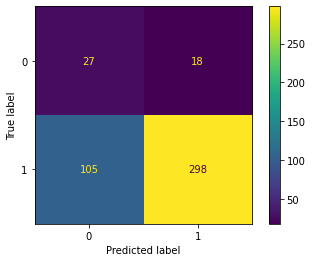

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

Añadimos a test no. de emprendedores cada 1000 habitantes y n de crimenes del 96

quitamos substra year, ya que puede fallar para predicciones y añadimos la edad del prestatario

In [16]:
%%sql loans_train1 << SELECT  amount, duration, payments, A11, A13, A14, A16, substr(c.birth_number,0,3) age,
  CASE status WHEN "A" THEN 1
              WHEN "B" THEN 0
  END label
  FROM LOAN "1", ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION dp
  WHERE "1".account_id = a.account_id
  AND a.district_id = d.A1
  AND dp.account_id = a.account_id
  AND dp.account_id = c.client_id
  AND status in ("A","B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train1


DATAFRAME

In [17]:
df_train1 = loans_train1.DataFrame()
df_train1.head()

,amount,duration,payments,A11,A13,A14,A16,age,label
0,80952,24,3373,12541,0.43,167,99107,45,1
1,80952,24,3373,12541,0.43,167,99107,45,1
2,30276,12,2523,9104,2.07,123,2354,42,0
3,30276,12,2523,9893,4.72,96,5887,39,1
4,165960,24,6915,8427,1.54,107,1913,32,1


datos test

Para esta parte prestamos en ejecucion -> "C" y "D"

In [18]:
%%sql loans_test1 << SELECT  amount, duration, payments, A11, A13, A14, A16, substr(c.birth_number,0,3) age,
  CASE status WHEN "C" THEN 1
              WHEN "D" THEN 0
  END label
  FROM LOAN "1", ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION dp
  WHERE "1".account_id = a.account_id
  AND a.district_id = d.A1
  AND dp.account_id = a.account_id
  AND dp.account_id = c.client_id
  AND status in ("C","D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test1


dataframe

In [19]:
df_test1 = loans_test1.DataFrame()
df_test1.head()

,amount,duration,payments,A11,A13,A14,A16,age,label
0,318480,60,5308,8547,3.64,120,1542,70,0
1,110736,48,2307,8402,3.98,120,1099,73,1
2,265320,36,7370,8254,3.76,97,2325,55,0
3,352704,48,7348,9104,2.07,123,2354,80,1
4,162576,36,4516,9198,4.28,131,6132,67,1


Division entrenamiento y test

features entrada

In [20]:
features = ["amount", "duration", "payments","A11", "A13", "A14", "A16", "age"]

In [21]:
X_train1 = df_train1[features]
y_train1 = df_train1["label"]

X_test1 = df_test1[features]
y_test1 = df_test1["label"]

Normalizarlos usando standscaler

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train1) 
# transformación
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

Aplicamos Nainve Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train1, y_train1)
y_pred1 = clf.predict(X_test1)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test1.shape[0], (y_test1 != y_pred1).sum()))


Número de préstamos clasificados erroneamente 260 de un total de  153


Informe de resultados classification report

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred1, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.09      0.68      0.16        22
           1       0.93      0.39      0.55       238

    accuracy                           0.41       260
   macro avg       0.51      0.53      0.35       260
weighted avg       0.86      0.41      0.51       260



Matriz de confusion

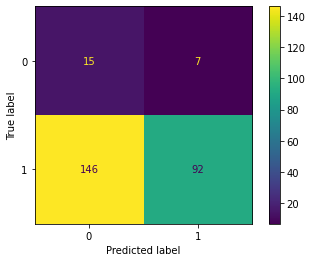

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test1, y_pred1, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Hemos acertado 107, mientras hemos fallado 153. Esto es un 43% de acierto. Ha disminuido mucho la precision del predictor frente al anterior que tenia un 72,5% de probabilidad de acierto.

**Vamos a probar de nuevo omitiendo variables**

Puede ser que se hay incluido variables no relevantes en el modelo por lo que haya bajado la precision de acierto

nuevo df

In [26]:
%%sql loans_train2 << SELECT  amount, duration, payments, A11, A13, substr(c.birth_number,0,3) age,
  CASE status WHEN "A" THEN 1
              WHEN "B" THEN 0
  END label
  FROM LOAN "1", ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION dp
  WHERE "1".account_id = a.account_id
  AND a.district_id = d.A1
  AND dp.account_id = a.account_id
  AND dp.account_id = c.client_id
  AND status in ("A","B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train2


In [27]:
df_train2 = loans_train2.DataFrame()
df_train2.head()

,amount,duration,payments,A11,A13,age,label
0,80952,24,3373,12541,0.43,45,1
1,80952,24,3373,12541,0.43,45,1
2,30276,12,2523,9104,2.07,42,0
3,30276,12,2523,9893,4.72,39,1
4,165960,24,6915,8427,1.54,32,1


datos test

In [28]:
%%sql loans_test2 << SELECT  amount, duration, payments, A11, A13, substr(c.birth_number,0,3) age,
  CASE status WHEN "C" THEN 1
              WHEN "D" THEN 0
  END label
  FROM LOAN "1", ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION dp
  WHERE "1".account_id = a.account_id
  AND a.district_id = d.A1
  AND dp.account_id = a.account_id
  AND dp.account_id = c.client_id
  AND status in ("C","D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test2


In [29]:
df_test2 = loans_test2.DataFrame()
df_test2.head()

,amount,duration,payments,A11,A13,age,label
0,318480,60,5308,8547,3.64,70,0
1,110736,48,2307,8402,3.98,73,1
2,265320,36,7370,8254,3.76,55,0
3,352704,48,7348,9104,2.07,80,1
4,162576,36,4516,9198,4.28,67,1


Division test y train

In [30]:
features = ["amount", "duration", "payments","A11", "A13", "age"]

In [31]:
X_train2 = df_train2[features]
y_train2 = df_train2["label"]

X_test2 = df_test2[features]
y_test2 = df_test2["label"]

Normalizar

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train2) 
# transformación
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

Aplicamos Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2.shape[0], (y_test2 != y_pred2).sum()))


Número de préstamos clasificados erroneamente 260 de un total de  121


Clasification report

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.10      0.59      0.18        22
           1       0.93      0.53      0.68       238

    accuracy                           0.53       260
   macro avg       0.52      0.56      0.43       260
weighted avg       0.86      0.53      0.63       260



Matriz de confusion

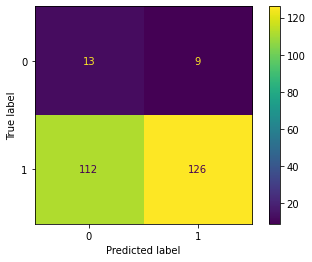

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test2, y_pred2, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Se puede observar que al eliminar las variables del no. de emprendedores cada 1000 habitantes y n de crimenes del 96, nuestro modelo ha mejorado con una precision del 53%. Aunque sigue siendo inferior al primer modelo.
